In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import read_csv
!pip install pmdarima
from statsmodels.tsa.arima.model import ARIMA

In [2]:
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_squared_error

In [3]:
train = pd.read_csv('Walmart_sales_train.csv')
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [5]:
train.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


We may see that some rows have negative values. We skipped those rows because sales can't be negative

In [6]:
train = train[train['Weekly_Sales'] >= 0]

We may see the following columns:

Store - the store number
Dept - the department number
Date - the week
Weekly_Sales - sales for the given department in the given store
IsHoliday - whether the week is a special holiday week
Let’s limit the data to only 1 store and 1 department for illustrative purpose.


In [7]:
data = train.loc[(train.Store == 1) & (train.Dept == 1),['Date','Weekly_Sales']]
print('Earliest date: %s; Latest date: %s' % (data['Date'].min(), data['Date'].max()))

Earliest date: 2010-02-05; Latest date: 2012-10-26


In [8]:
data.head()

,Date,Weekly_Sales
0,2010-02-05,24924.50
1,2010-02-12,46039.49
2,2010-02-19,41595.55
3,2010-02-26,19403.54
4,2010-03-05,21827.90


In [9]:
data.set_index('Date', inplace=True)

In [10]:
data.groupby('Date')

In [11]:
data.index

Index(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26', '2010-03-05',
       '2010-03-12', '2010-03-19', '2010-03-26', '2010-04-02', '2010-04-09',
       ...
       '2012-08-24', '2012-08-31', '2012-09-07', '2012-09-14', '2012-09-21',
       '2012-09-28', '2012-10-05', '2012-10-12', '2012-10-19', '2012-10-26'],
      dtype='object', name='Date', length=143)

## Data Visualization

<AxesSubplot:title={'center':'Walmart Sales in One Department of One Store Feb 2010 to Oct 2012'}, xlabel='Date'>

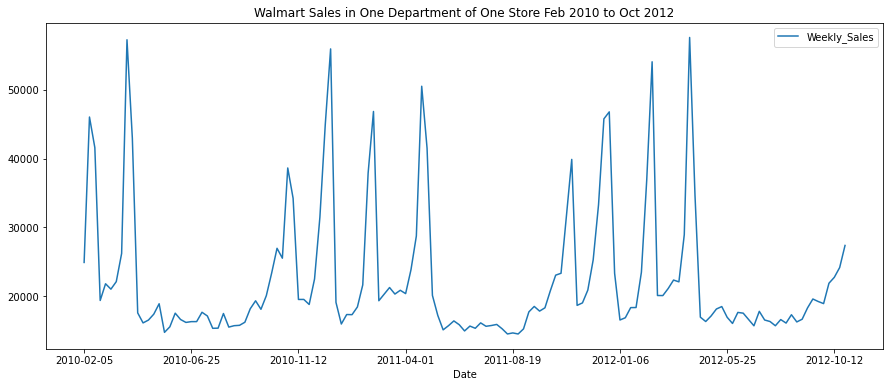

In [12]:
%matplotlib inline
# plot data
data.plot(figsize=(15, 6),title="Walmart Sales in One Department of One Store Feb 2010 to Oct 2012")

We can see that there are spikes in sales around November, December, February, and April.

In [13]:
data.index = pd.to_datetime(data.index)#chanching to datetime format

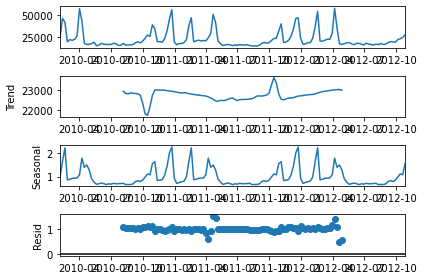

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data, model='multiplicative')
fig = result.plot()

On the plots we can see the trend and the seasonal component of the data.

Statistical Test
We can perform statistical testing to make sure the data is stationary. Stationarity in time series means that the variance and mean are constant over time.
If p-value <0.05; The data is stationary.
If p-value > 0.05; Data are not stationary.

In [15]:
def ad_test(data):
    
    dftest = adfuller(data, autolag = 'AIC')
    
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:",dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
         print("\t",key, ": ", val)
         
         
ad_test(data['Weekly_Sales'])

1. ADF :  -2.522163868650038
2. P-Value :  0.1101743228258697
3. Num Of Lags :  6
4. Num Of Observations Used For ADF Regression: 136
5. Critical Values :
	 1% :  -3.4793722137854926
	 5% :  -2.8830370378332995
	 10% :  -2.578233635380623


We see that our data is not stationary. To make this data stationary, we need to give the “d” value of the ARIMA Model 1. If the time series is non-stationary, taking the difference is a great way. If your time series data is non-stationary, use differencing. It’s an extremely powerful technique. If the 1st order differentiation doesn’t work, you can use 2nd order differencing.

## Forecast Model

ARIMA is one of the most popular and widely used statistical methods for time series forecasting.
ARIMA (Autoregressive Integrated Moving Average) also called Box-Jenkins models. 

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations. AR(1): a linear model to predict the value at the present time using the value at the previous time.

I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

ARIMA models are commonly denoted as ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used. 
We have 3 parameters in ARIMA(p,q,d):
p is from Auto Regression, q is from Moving Averages, and d is from differencing.A value of 0 can be used for a parameter, which indicates to not use that element of the model. The ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.


SARIMA(p, q, d)(P, Q, D)m.

We know the ARIMA model. AR is auto regressive, which says we want to predict the time series values based on some periods in the past. I is integrating, which is an upward or downward trend and to get rid of it, we use differencing. MA is moving average, which is informing the errors from the previous period to the next period. The new thing we see here is S – seasonality.
In SARIMA(P, Q, D)m: m is the seasonal factor. It’s the number of time steps for a single seasonal period.

In [16]:
#Let’s build the ARIMA model using pmdarima‘s auto_arima().
#To do that, we need to use seasonal=True, the frequency m=12 for month series and set D=1.
from pmdarima import auto_arima
stepwise_model = auto_arima(data, start_p=1, d=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.62 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2840.830, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2804.538, Time=0.33 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2785.696, Time=0.32 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2840.080, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2787.351, Time=0.49 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2787.311, Time=1.12 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2804.768, Time=0.32 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=7.67 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=1.43 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=3.09 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.65 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total 

Now we can use the best model parameters and validate the model performance by splitting the data into a train and a test set.

In [17]:
train = data.loc[:'2012-05-01']
test = data.loc['2012-05-01':]
stepwise_model.fit(train)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

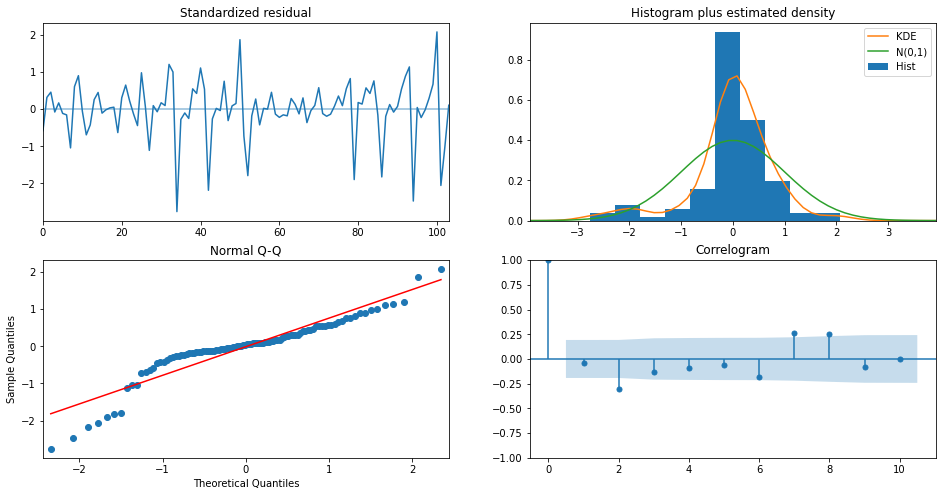

In [18]:
stepwise_model.fit(train).plot_diagnostics(figsize=(16, 8))
plt.show()

Standardized residual: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Histogram plus estimated density: The density plot suggest normal distribution with mean zero.

Normal Q-Q: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Correlogram (ACF) shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. 

It should be a good fit. Time to forecast.

In [19]:
future_forecast = stepwise_model.predict(n_periods=len(test))

<AxesSubplot:xlabel='Date'>

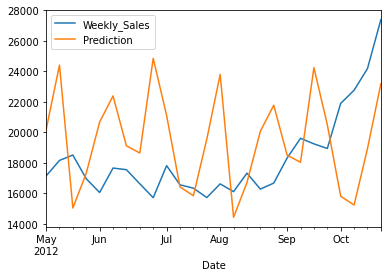

In [20]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
pd.concat([test,future_forecast],axis=1).plot()

In [22]:
from sklearn import metrics
print('Mean Absolute error: ', metrics.mean_absolute_error(test,future_forecast))
print('Mean Absolute persentage error: ', metrics.mean_absolute_percentage_error(test,future_forecast))
print('Mean Squared Error: ', metrics.mean_squared_error(test,future_forecast))
print('Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(test,future_forecast)))

Mean Absolute error:  3562.1809889742353
Mean Absolute persentage error:  0.19464201002322004
Mean Squared Error:  18585313.374403983
Root Mean Squared Error:  4311.068704440232


Around 19% MAPE implies the model is about 81% accurate. Not great, but not so bad.

<AxesSubplot:title={'center':'Walmart Sales in One Department of One Store Feb 2010 to Oct 2012'}, xlabel='Date'>

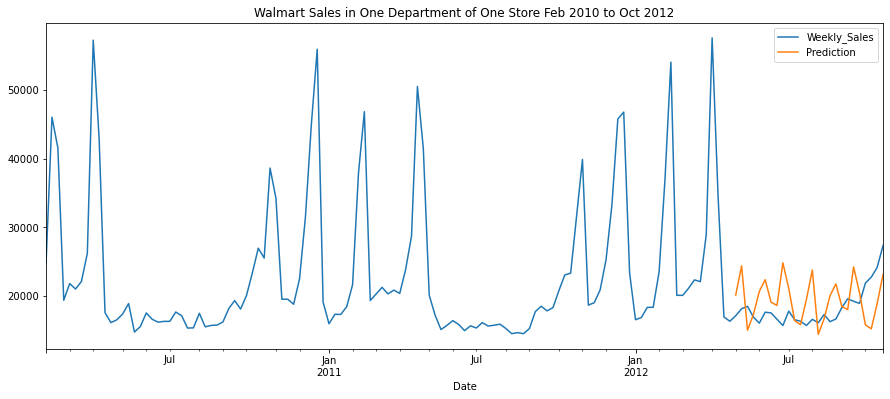

In [23]:
pd.concat([data,future_forecast],axis=1).plot(figsize=(15, 6),
title="Walmart Sales in One Department of One Store Feb 2010 to Oct 2012")

https://neptune.ai/blog/arima-sarima-real-world-time-series-forecasting-guide